## Financial Engineering: Options Hedging with Greeks

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as si
from scipy.optimize import fsolve

Black-Scholes option price, delta, gamma, and vega

In [2]:
def black_scholes_greeks(S, K, T, r, sigma, option_type="call"):
    """
    Calculate the Black-Scholes option price, delta, gamma, and vega.
    
    Parameters:
    - S: Spot price of the underlying asset
    - K: Strike price
    - T: Time to maturity (in years)
    - r: Risk-free interest rate (annual)
    - sigma: Volatility of the underlying asset (annual)
    - option_type: Type of the option ("call" or "put")
    
    Returns:
    - Option price
    - Delta of the option
    - Gamma of the option
    - Vega of the option
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == "call":
        option_price = S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
        delta = si.norm.cdf(d1, 0.0, 1.0)
    else:
        option_price = K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * si.norm.cdf(-d1, 0.0, 1.0)
        delta = -si.norm.cdf(-d1, 0.0, 1.0)
    
    gamma = si.norm.pdf(d1, 0.0, 1.0) / (S * sigma * np.sqrt(T))
    vega = S * si.norm.pdf(d1, 0.0, 1.0) * np.sqrt(T)
    
    return option_price, delta, gamma, vega

Value of a unhedged portfolio for a new stock price one day forward

In [3]:
def unhedged_portfolio_next_day(S_0, S_1, K, T, r, sigma, number_of_options, option_type="call"):
    """
    Calculate the value of an unhedged portfolio for a new stock price one day forward.
    
    Parameters:
    - S_0: The initial stock price.
    - S_1: The new stock price.
    - K: The strike price of the option.
    - T: The original time to maturity for the option, in years.
    - r: The risk-free interest rate, annualized.
    - sigma: The volatility of the underlying asset, annualized.
    - number_of_options: The number of options sold.
    - option_type: The type of the option ("call" or "put").
    
    Returns:
    - V_unhedged: The total value of the unhedged portfolio after one day, given the new stock price.
    """
    # Adjust time to maturity for the next day
    T_1 = T - 1/365
    
    # Recalculate option price for the new stock price
    new_option_price, _, _, _ = black_scholes_greeks(S_1, K, T_1, r, sigma, option_type)

    # Calculate the initial option value from selling options
    initial_option_price, _, _, _ = black_scholes_greeks(S_0, K, T, r, sigma, option_type)
    initial_option_value = initial_option_price * number_of_options
    
    # Initial cash position is the proceeds from selling the options
    initial_cash_position = initial_option_value
    
    # New option value (since options are sold, the entire option value affects the portfolio)
    new_option_value = new_option_price * number_of_options
    
    # Adjust the initial cash position by the risk-free rate for one day
    cash_position_next_day = initial_cash_position * np.exp(r * 1/365)

    # Total unhedged portfolio value
    V_unhedged = new_option_value - cash_position_next_day
    
    return V_unhedged

Value of a delta-hedged portfolio for a new stock price one day forward

In [4]:
def delta_hedge_portfolio_next_day(S_0, S_1, K, T, r, sigma, number_of_options, option_type="call"):
    """
    Calculate the value of a delta-hedged portfolio for a new stock price one day forward.
    
    Parameters:
    - S_0: The initial stock price used in the delta hedging.
    - S_1: The new stock price.
    - K: The strike price of the option.
    - T: The original time to maturity for the option, in years.
    - r: The risk-free interest rate, annualized.
    - sigma: The volatility of the underlying asset, annualized.
    - number_of_options: The number of options sold.
    - option_type: The type of the option ("call" or "put").
    
    Returns:
    - V_hedged: The total value of the delta-hedged portfolio after one day, given the new stock price.
    """
    # Calculate the initial option value from selling options
    initial_option_price, initial_delta, _, _ = black_scholes_greeks(S_0, K, T, r, sigma, option_type)
    initial_option_value = initial_option_price * number_of_options  
    
    # Cost of buying stocks to hedge
    initial_stock_position_cost = -initial_delta * number_of_options * S_0
    
    # Initial cash position is the net of these two
    initial_cash_position = -(initial_option_value + initial_stock_position_cost)
    
    # Adjust time to maturity for the next day
    T_1 = T - 1/365
    
    # Recalculate option price for the new stock price
    new_option_price, _, _, _ = black_scholes_greeks(S_1, K, T_1, r, sigma, option_type)

    # Value from the new stock position using original delta hedge ratio and the new stock price
    stock_position_value = -initial_delta * number_of_options * S_1

    # Calculate the total value of the option position with the new option price
    new_option_value = new_option_price * number_of_options

    # Adjust the initial cash position for one day's worth of interest at the risk-free rate
    cash_position_next_day = initial_cash_position * np.exp(r * 1/365)

    # Calculate the total value of the delta-hedged portfolio with the updated positions
    V_hedged = stock_position_value + cash_position_next_day + new_option_value

    return V_hedged

Value of a delta-gamma-hedged portfolio for a new stock price one day forward

In [5]:
def delta_gamma_hedge_portfolio_next_day(S_0, S_1, K, K1, T, T1, r, sigma, number_of_options, position_in_stock, position_in_second_option, option_type="call"):
    """
    Calculate the value of a delta-gamma-hedged portfolio for a new stock price one day forward.

    Parameters:
    - S_0: The initial stock price used in the delta-gamma hedging.
    - S_1: The new stock price.
    - K: The strike price of the first option.
    - K1: The strike price of the second option.
    - T: The original time to maturity for the first option, in years.
    - T1: The original time to maturity for the second option, in years.
    - r: The risk-free interest rate, annualized.
    - sigma: The volatility of the underlying asset, annualized.
    - number_of_options: The number of first options sold.
    - position_in_stock: The number of shares of the underlying stock to hold for delta-gamma neutrality.
    - position_in_second_option: The number of second options to hold for delta-gamma neutrality.
    - option_type: The type of the options ("call" or "put").

    Returns:
    - V_hedged: The total value of the delta-gamma-hedged portfolio after one day, given the new stock price.
    """
    # Adjust time to maturity for the next day
    T_1 = T - 1/365
    T1_1 = T1 - 1/365
    
    # Recalculate option prices for the new stock price
    new_option_price, _, _, _ = black_scholes_greeks(S_1, K, T_1, r, sigma, option_type)
    new_option_price1, _, _, _ = black_scholes_greeks(S_1, K1, T1_1, r, sigma, option_type)

    # Calculate the initial option value from selling the first options
    initial_option_price, _, _, _ = black_scholes_greeks(S_0, K, T, r, sigma, option_type)
    initial_option_price1, _, _, _ = black_scholes_greeks(S_0, K1, T1, r, sigma, option_type)
    initial_option_value = initial_option_price * number_of_options
    initial_option_value1 = initial_option_price1 * position_in_second_option

    # Cost of buying stocks to hedge
    initial_stock_position_cost = position_in_stock * S_0

    # Initial cash position is the proceeds from selling the first options
    initial_cash_position = -(initial_option_value + initial_stock_position_cost + initial_option_value1)

    # New option values
    new_option_value = new_option_price * number_of_options
    new_option_value1 = new_option_price1 * position_in_second_option

    # Value from the new stock position
    stock_position_value = position_in_stock * S_1

    # Adjust the initial cash position for one day's worth of interest at the risk-free rate
    cash_position_next_day = initial_cash_position * np.exp(r * 1/365)

    # Calculate the total value of the portfolio with the updated positions
    V_hedged = stock_position_value + cash_position_next_day + new_option_value + new_option_value1

    return V_hedged


Value of a delta-vega-hedged portfolio for a new stock price one day forward

In [6]:
def delta_vega_hedge_portfolio_next_day(S_0, S_1, K, K1, T, T1, r, sigma, sigma2, number_of_options, position_in_stock, position_in_second_option, option_type="call"):
    """
    Calculate the value of a delta-vega-hedged portfolio for a new stock price one day forward.

    Parameters:
    - S_0: The initial stock price used in the delta-vega hedging.
    - S_1: The new stock price.
    - K: The strike price of the first option.
    - K1: The strike price of the second option.
    - T: The original time to maturity for the first option, in years.
    - T1: The original time to maturity for the second option, in years.
    - r: The risk-free interest rate, annualized.
    - sigma: The volatility of the underlying asset, annualized.
    - sigma2: The volatility of the underlying asset, annualized, for the next day.
    - number_of_options: The number of first options sold.
    - position_in_stock: The number of shares of the underlying stock to hold for delta-vega neutrality.
    - position_in_second_option: The number of second options to hold for delta-vega neutrality.
    - option_type: The type of the options ("call" or "put").

    Returns:
    - V_hedged: The total value of the delta-vega-hedged portfolio after one day, given the new stock price.
    """    
    # Adjust time to maturity for the next day
    T_1 = T - 1/365
    T1_1 = T1 - 1/365

    # Calculate the initial option value from selling the first options and the position in the second option
    initial_option_price, _, _, _ = black_scholes_greeks(S_0, K, T, r, sigma, option_type)
    initial_option_price1, _, _, _ = black_scholes_greeks(S_0, K1, T1, r, sigma, option_type)
    initial_option_value = initial_option_price * number_of_options
    initial_option_value1 = initial_option_price1 * position_in_second_option
    
    # Cost of buying stocks to hedge
    initial_stock_position_cost = position_in_stock * S_0
    
     # Initial cash position is the proceeds from selling the first options
    initial_cash_position = -(initial_option_value + initial_stock_position_cost + initial_option_value1)   
    
    # Recalculate option prices for the new stock price
    new_option_price, _, _, _ = black_scholes_greeks(S_1, K, T_1, r, sigma2, option_type)
    new_option_price1, _, _, _ = black_scholes_greeks(S_1, K1, T1_1, r, sigma2, option_type)
    new_option_value = new_option_price * number_of_options
    new_option_value1 = new_option_price1 * position_in_second_option
    
    # Value from the new stock position
    stock_position_value = position_in_stock * S_1
    
    # Adjust the initial cash position for one day's worth of interest at the risk-free rate
    cash_position_next_day = initial_cash_position * np.exp(r * 1/365)
    
    # Calculate the total value of the portfolio with the updated positions
    V_hedged = stock_position_value + cash_position_next_day + new_option_value + new_option_value1

    return V_hedged


Parameters

In [20]:
# Inputs
S_0 = 726  # Initial stock price
K = 700  # Strike price
K1 = 695
T = 273/365  # Time to maturity
T1 = 126/365
r = 0.043  # Risk-free interest rate
sigma = 0.4567  # Volatility
sigma2 = 0.5 
number_of_options = -100  # Number of options sold
stock_prices_next_day = [650, 670, 706, 716, 726, 736, 746, 780, 800]

In [21]:
# Calculate Greeks for both options
price_original, delta_original, gamma_original, vega_original = black_scholes_greeks(S_0, K, T, r, sigma, "call")
price_first, delta_first, gamma_first, vega_first = black_scholes_greeks(S_0, K, T, r, sigma, "call")
price_second, delta_second, gamma_second, vega_second = black_scholes_greeks(S_0, K1, T1, r, sigma, "call")


# Create a DataFrame to display the options' greeks
df_results = pd.DataFrame({
    "Option": ["Option 1 (K=700)", "Option 2 (K=695)"],
    "Price": [price_first, price_second],
    "Delta": [delta_first, delta_second],
    "Gamma": [gamma_first, gamma_second],
    "Vega": [vega_first, vega_second]
})

# Display the DataFrame
display(df_results)


# Calculate the number of shares for delta hedging
position_in_stock = -delta_original * number_of_options
print("Delta Hedging:")
print(f"Position in stock (for delta neutrality): {position_in_stock}\n")


# Solve for delta-gamma hedging
def solve_for_hedging(variables):
    position_in_stock, position_in_second_option = variables
    # Delta neutrality equation
    delta_eq = (delta_first * number_of_options) + (delta_second * position_in_second_option) + position_in_stock
    # Gamma neutrality equation
    gamma_eq = (gamma_first * number_of_options) + (gamma_second * position_in_second_option)
    return [delta_eq, gamma_eq]

# Initial guesses for stock and second option positions
initial_guesses = [0, 0]

# Solve the system of equations
position_stock_delta_gamma, position_second_option_delta_gamma = fsolve(solve_for_hedging, initial_guesses)

print("Delta-Gamma Hedging:")
print(f"Position in stock (for delta-gamma neutrality): {position_stock_delta_gamma}")
print(f"Position in second option (for delta-gamma neutrality): {position_second_option_delta_gamma}\n")


# Function to solve for delta-vega hedging
def solve_for_delta_vega_hedging(variables):
    position_in_stock, position_in_second_option = variables
    # Delta neutrality equation
    delta_eq = (delta_first * number_of_options) + (delta_second * position_in_second_option) + position_in_stock
    # Vega neutrality equation, instead of gamma neutrality for delta-vega hedging
    vega_eq = (vega_first * number_of_options) + (vega_second * position_in_second_option)
    return [delta_eq, vega_eq]

# Initial guesses for stock and second option positions
initial_guesses_for_delta_vega = [0, 0]

# Solve the system of equations for delta-vega hedging
position_stock_delta_vega, position_second_option_delta_vega = fsolve(solve_for_delta_vega_hedging, initial_guesses_for_delta_vega)

print("Delta-Vega Hedging:")
print(f"Position in stock (for delta-vega neutrality): {position_stock_delta_vega}")
print(f"Position in second option (for delta-vega neutrality): {position_second_option_delta_vega}")


,Option,Price,Delta,Gamma,Vega
0,Option 1 (K=700),135.597877,0.644774,0.001299,233.804661
1,Option 2 (K=695),97.673657,0.637623,0.001925,159.942119


Delta Hedging:
Position in stock (for delta neutrality): 64.47737669620157

Delta-Gamma Hedging:
Position in stock (for delta-gamma neutrality): 21.458175530201324
Position in second option (for delta-gamma neutrality): 67.46805915649009

Delta-Vega Hedging:
Position in stock (for delta-vega neutrality): -28.73089249679895
Position in second option (for delta-vega neutrality): 146.1807948390618


Performance Comparison of Portfolio Values under Different Hedging Strategies

In [22]:
# Dataframe to store results
df_results = pd.DataFrame(index=stock_prices_next_day)
df_results2 = pd.DataFrame(index=stock_prices_next_day)

# Comparison of Unhedged, Delta-Neutral, Delta-Gamma Neutral Portfolios with changes in price
print("Comparison of Unhedged, Delta-Neutral, Delta-Gamma Neutral Portfolios:")
for S_1 in stock_prices_next_day:
    V_unhedged = unhedged_portfolio_next_day(S_0, S_1, K, T, r, sigma, number_of_options, "call")
    V_delta_hedged = delta_hedge_portfolio_next_day(S_0, S_1, K, T, r, sigma, number_of_options, "call")
    V_delta_gamma_hedged = delta_gamma_hedge_portfolio_next_day(S_0, S_1, K, K1, T, T1, r, sigma, number_of_options, position_stock_delta_gamma, position_second_option_delta_gamma, "call")

    df_results.loc[S_1, 'Unhedged'] = V_unhedged
    df_results.loc[S_1, 'Delta'] = V_delta_hedged
    df_results.loc[S_1, 'Delta-Gamma'] = V_delta_gamma_hedged

display(df_results)

# Comparison of Unhedged, Delta-Neutral, Delta-Gamma Neutral Portfolios with changes in volatility
print("\nComparison of Unhedged, Delta-Neutral, Delta-Vega Neutral Portfolios:")
for S_1 in stock_prices_next_day:
    V_unhedged= unhedged_portfolio_next_day(S_0, S_1, K, T, r, sigma2, number_of_options, "call")
    V_delta_hedged = delta_hedge_portfolio_next_day(S_0, S_1, K, T, r, sigma2, number_of_options, "call")
    V_delta_vega_hedged = delta_vega_hedge_portfolio_next_day(S_0, S_1, K, K1, T, T1, r, sigma, sigma2, number_of_options, position_stock_delta_vega, position_second_option_delta_vega, "call")    

    df_results2.loc[S_1, 'Unhedged'] = V_unhedged
    df_results2.loc[S_1, 'Delta'] = V_delta_hedged
    df_results2.loc[S_1, 'Delta-Vega'] = V_delta_vega_hedged

display(df_results2)


Comparison of Unhedged, Delta-Neutral, Delta-Gamma Neutral Portfolios:


,Unhedged,Delta,Delta-Gamma
650,4523.702738,-382.092886,2.525523
670,3421.039928,-195.208162,1.151487
706,1287.898837,-7.163693,-0.087538
716,663.174122,12.885359,-0.097267
726,25.091305,19.576310,-0.020568
736,-626.002972,13.255799,0.081799
746,-1289.760262,-5.727724,0.135229
780,-3636.558367,-160.295021,-1.277217
800,-5078.029163,-312.218283,-4.454666



Comparison of Unhedged, Delta-Neutral, Delta-Vega Neutral Portfolios:


,Unhedged,Delta,Delta-Vega
650,4571.621156,-344.582062,446.726565
670,3449.538391,-174.381531,235.037178
706,1294.787843,-3.022148,14.670482
716,666.945743,15.277400,-11.560314
726,26.929827,21.403131,-23.343059
736,-624.954780,15.660172,-21.136692
746,-1288.402914,-1.646314,-5.423415
780,-3626.535480,-142.897278,142.184118
800,-5057.949056,-282.027559,290.936828


Plotting Different Hedging Strategies

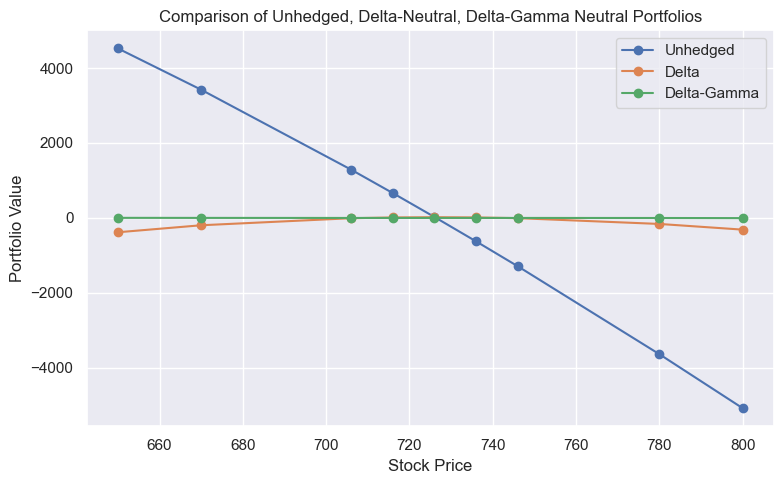

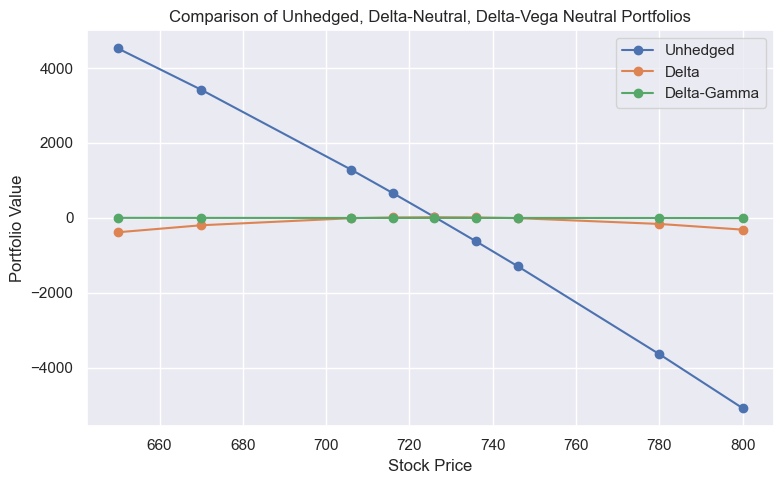

In [23]:
def plot_portfolio_comparison(df, line_columns, title, xlabel="Stock Price", ylabel="Portfolio Value", figsize=(8, 5)):
    """
    Takes a DataFrame and plots each column as a line on a graph.
    
    Parameters:
    - df: DataFrame containing the data to plot.
    - line_columns: List of column names to plot as lines.
    - title: The title of the plot.
    - xlabel: The label for the x-axis.
    - ylabel: The label for the y-axis.
    - figsize: Tuple representing the figure size.
    """
    # Ensure 'Stock Price' is a column in the DataFrame
    df = df_results.reset_index().rename(columns={'index': 'Stock Price'})

    # Set the style
    sns.set_theme(style="darkgrid")

    # Create the plot
    plt.figure(figsize=figsize)
    for column in line_columns:
        plt.plot(df['Stock Price'], df[column], marker='o', label=column)

    # Add titles and labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

    
# Comparison of Unhedged, Delta-Neutral, Delta-Gamma Neutral Portfolios with changes in price
plot_portfolio_comparison(df_results, ['Unhedged', 'Delta', 'Delta-Gamma'],
                          'Comparison of Unhedged, Delta-Neutral, Delta-Gamma Neutral Portfolios',
                          'Stock Price', 'Portfolio Value')


# Comparison of Unhedged, Delta-Neutral, Delta-Vega Neutral Portfolios with changes in volatility
plot_portfolio_comparison(df_results2, ['Unhedged', 'Delta', 'Delta-Gamma'],
                          'Comparison of Unhedged, Delta-Neutral, Delta-Vega Neutral Portfolios',
                          'Stock Price', 'Portfolio Value')